# Manipulation Methods

In [2]:
import math
import sys
import os

import pandas as pd
import numpy as np
import pyarrow as pa

sys.path.append(os.path.abspath(".."))

from extras.utils import load_vehicle_data

## Loading data

In [3]:
df = load_vehicle_data()
# Generating Series
city_mpg = df.city08
highway_mpg = df.highway08

## .apply and .where

Although handy, the .apply method is often misused and bears slow results

In [4]:
def gt20(val):
    return val > 20

In [5]:
%%timeit
city_mpg.apply(gt20)

4.88 ms ± 261 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%%timeit
city_mpg.gt(20)

84.9 μs ± 4.39 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The existing .gt method is faster per loop than using .apply

In [7]:
make = df.make

In [8]:
make.value_counts()

make
Chevrolet                           4003
Ford                                3371
Dodge                               2583
GMC                                 2494
Toyota                              2071
                                    ... 
Grumman Allied Industries              1
Environmental Rsch and Devp Corp       1
General Motors                         1
Goldacre                               1
Isis Imports Ltd                       1
Name: count, Length: 136, dtype: int64[pyarrow]

We will keep only the top 5 values, renaming the others to "Other"

In [9]:
top_5 = make.value_counts().index[:5]
top_5

Index(['Chevrolet', 'Ford', 'Dodge', 'GMC', 'Toyota'], dtype='string[pyarrow]', name='make')

In [10]:
def generalize_top5(val):
    if val in top_5:
        return val
    return "Other"

In [11]:
%%timeit
make.apply(generalize_top5)

33.3 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit
make.where(make.isin(top_5), other="Other")

1.81 ms ± 90.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


A complement to the .where method is the .mask method, where if a condition is False it keeps it and if it is True it replaces the value. 
So, the mask version of the previous code is:

In [13]:
make.mask(~make.isin(top_5), other="Other")

0        Other
1        Other
2        Dodge
3        Dodge
4        Other
         ...  
41139    Other
41140    Other
41141    Other
41142    Other
41143    Other
Name: make, Length: 41144, dtype: string[pyarrow]

## Apply with NumPy Functions
There are cases where .apply is handy. If working with NumPy functions that works on arrays, .apply would broadcast it to the entire series.

To exemplify, we will time the application of np.log and math.log, the latter not beint a function that works on arrays.

In [14]:
%%timeit
city_mpg.apply(np.log)

156 μs ± 4.06 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [15]:
%%timeit
city_mpg.apply(math.log)

4.96 ms ± 222 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## If Else with Pandas

One of the shortcoming of pandas is that there is no direct way to do this, there needs to be a combination of functions. Let's try now to build from the top 5 function, now to distinguish cars that are Top10 (not mentioning the make, just labeling as Top10)

In [16]:
vc = make.value_counts()
top5 = vc.index[:5]
top10 = vc.index[:10]

def generalize(val):
    if val in top5:
        return val
    elif val in top10:
        return "Top10"
    else:
        return "Other"

In [17]:
make.apply(generalize)

0        Other
1        Other
2        Dodge
3        Dodge
4        Other
         ...  
41139    Other
41140    Other
41141    Other
41142    Other
41143    Other
Name: make, Length: 41144, dtype: object

In [19]:
%%timeit
make.apply(generalize)

53.5 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


A fairly recent addition in pandas 2.2 is the .case_when method. This takes a tuple, where the first item is a boolean array and the second item is the values when the boolean is True. So for example, in the next cell the first case will have True for those cars that are in the top 5 and the second item is the whole make series, so whenever the value is True, the make of the car is passed. The last case is just to take everything that is left and label it as Other.

In [18]:
(
    make
    .case_when(
        caselist=[
            (make.isin(top5), make),
            (make.isin(top10), "Top10"),
            (pd.Series(True, index=make.index), "Other")
        ]
    )
)

0        Other
1        Other
2        Dodge
3        Dodge
4        Other
         ...  
41139    Other
41140    Other
41141    Other
41142    Other
41143    Other
Name: make, Length: 41144, dtype: object

In [20]:
%%timeit
(
    make
    .case_when(
        caselist=[
            (make.isin(top5), make),
            (make.isin(top10), "Top10"),
            (pd.Series(True, index=make.index), "Other")
        ]
    )
)

9.52 ms ± 513 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The .where can also be used by chaining them, although this is a bit harder to read as it doesn't follow the traditional if then methodology.

In [21]:
(
    make
    .where(make.isin(top5), "Top10")
    .where(make.isin(top10), "Other")
)

0        Other
1        Other
2        Dodge
3        Dodge
4        Other
         ...  
41139    Other
41140    Other
41141    Other
41142    Other
41143    Other
Name: make, Length: 41144, dtype: string[pyarrow]

In [22]:
%%timeit
(
    make
    .where(make.isin(top5), "Top10")
    .where(make.isin(top10), "Other")
)

3.75 ms ± 233 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Filling in Missing Data

In [27]:
cyl = df.cylinders

In [28]:
cyl[cyl.isna()]

7138     <NA>
7139     <NA>
8143     <NA>
8144     <NA>
8146     <NA>
         ... 
34563    <NA>
34564    <NA>
34565    <NA>
34566    <NA>
34567    <NA>
Name: cylinders, Length: 206, dtype: int64[pyarrow]

Electric cars don't have cylinders, so here it is seen as null. We will replace this with zero

In [ ]:
cyl.fillna(0).loc[7136:7141]

7136    6
7137    6
7138    0
7139    0
7140    6
7141    6
Name: cylinders, dtype: int64[pyarrow]

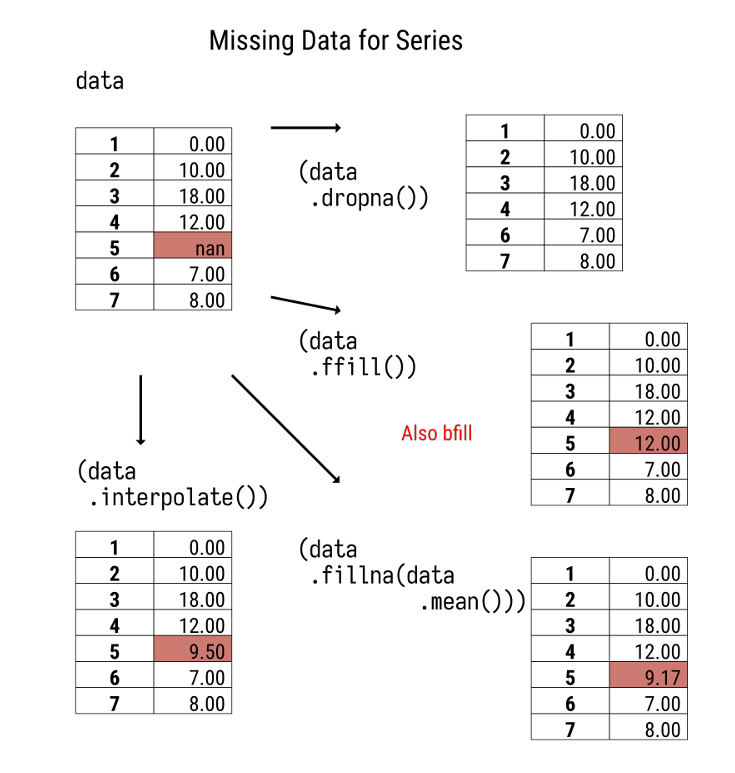

## Interpolating Data

An option that comes specially handy if data is ordered and there are holes in the data

In [32]:
temp = pd.Series(
    [32, 40, None, 42, 39, 32],
    dtype="float[pyarrow]"
)
temp

0    32.0
1    40.0
2    <NA>
3    42.0
4    39.0
5    32.0
dtype: float[pyarrow]

In [33]:
temp.interpolate()

0    32.0
1    40.0
2    41.0
3    42.0
4    39.0
5    32.0
dtype: float[pyarrow]

## Clipping data
Good for unwanted outliers

In [35]:
city_mpg.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count      41144.0
mean     18.369045
std       7.905886
min            6.0
1%            10.0
5%            11.0
10%           13.0
25%           15.0
50%           17.0
75%           20.0
90%           24.0
95%           27.0
99%           40.0
max          150.0
Name: city08, dtype: double[pyarrow]

Taking only values between the 5th (11) and 95th (27) quantiles:

In [39]:
(
    city_mpg
    .clip(lower=city_mpg.quantile(.05),
          upper=city_mpg.quantile(.95))
)

0        19
1        11
2        23
3        11
4        17
         ..
41139    19
41140    20
41141    18
41142    18
41143    16
Name: city08, Length: 41144, dtype: int64[pyarrow]

Anything below the 5th quantile now is 11 and anything above the 95th quantile is 27.

## Sorting Values
If left by default, the .sort_values method will sort values in ascending orders, rearranging the index accordingly

In [41]:
city_mpg.sort_values()

7901       6
21060      6
34557      6
35887      6
37161      6
        ... 
34563    138
34564    140
31256    150
32599    150
33423    150
Name: city08, Length: 41144, dtype: int64[pyarrow]

Because of the index alignment, doing math (and other) operations works the same way as if the Series was not sorted, as it uses the index to select elements

In [45]:
ser1 = (city_mpg + highway_mpg) / 2
ser2 = (city_mpg.sort_values() + highway_mpg) / 2
ser1.equals(ser2)

True

## Sorting the Index

Similar to sort_values, but does it for the index. Below we first rearrange according to values, but revert it with the sort_index method

In [47]:
city_mpg.sort_values().sort_index()

0        19
1         9
2        23
3        10
4        17
         ..
41139    19
41140    20
41141    18
41142    18
41143    16
Name: city08, Length: 41144, dtype: int64[pyarrow]

## Dropping duplicates

In [56]:
print(
    " Original Series size:",
    city_mpg.shape[0],
    "\n",
    "Without duplicates:",
    city_mpg.drop_duplicates().shape[0]
)

 Original Series size: 41144 
 Without duplicates: 105


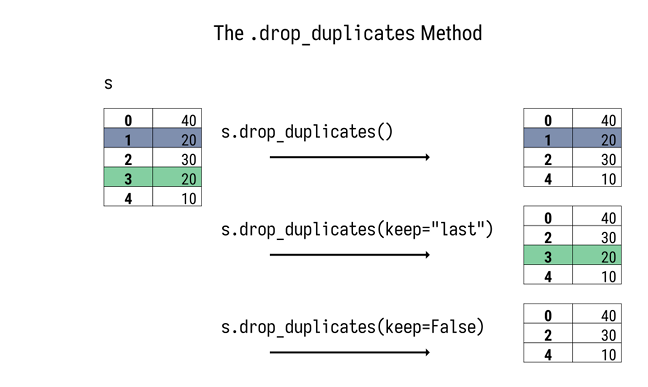

## Ranking Data
The .rank method uses the rank of values from the original series. 

In [57]:
city_mpg.rank()

0        27060.5
1          235.5
2        35830.0
3          607.5
4        19484.0
          ...   
41139    27060.5
41140    29719.5
41141    23528.0
41142    23528.0
41143    15479.0
Name: city08, Length: 41144, dtype: double[pyarrow]

If the method specified is min, equal values goes in the same rank. The next value will be ranked after the count of this values. So for example, if the first 2 values are equal, they are rank 1. Value 3 would be rank 3.

In [58]:
city_mpg.rank(method="min")

0        25555
1          136
2        35119
3          336
4        17467
         ...  
41139    25555
41140    28567
41141    21502
41142    21502
41143    13492
Name: city08, Length: 41144, dtype: uint64[pyarrow]

The dense method, will be the same as in min, but the third value would be rank 2. i.e., no rank is skipped.

In [59]:
city_mpg.rank(method="dense")

0        14
1         4
2        18
3         5
4        12
         ..
41139    14
41140    15
41141    13
41142    13
41143    11
Name: city08, Length: 41144, dtype: uint64[pyarrow]

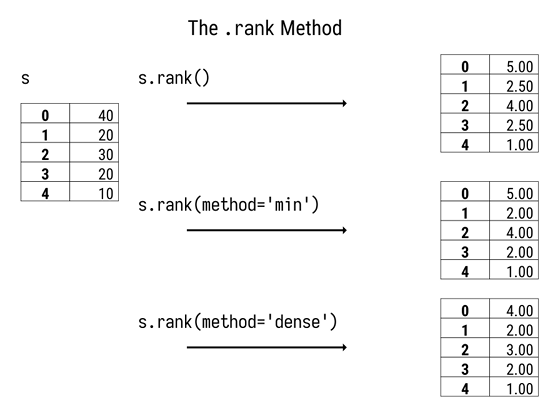

## Replacing Data
The .replace method helps mapping new values

In [60]:
make.replace("Subaru", "スバル")

0        Alfa Romeo
1           Ferrari
2             Dodge
3             Dodge
4               スバル
            ...    
41139           スバル
41140           スバル
41141           スバル
41142           スバル
41143           スバル
Name: make, Length: 41144, dtype: string[pyarrow]

The to_replace parameter can contain regex if regex is set to True. 
The following example uses capture groups (denoted by parenthesis) and then refers to these groups using \1 for the first group and \2 for the second.

In [61]:
make.replace(
    r"(Fer)ra(r.*)",
    value=r"\2-other-\1",
    regex=True
)

0          Alfa Romeo
1        ri-other-Fer
2               Dodge
3               Dodge
4              Subaru
             ...     
41139          Subaru
41140          Subaru
41141          Subaru
41142          Subaru
41143          Subaru
Name: make, Length: 41144, dtype: string[pyarrow]

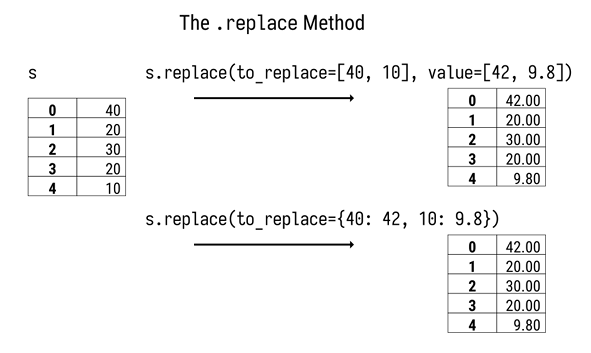

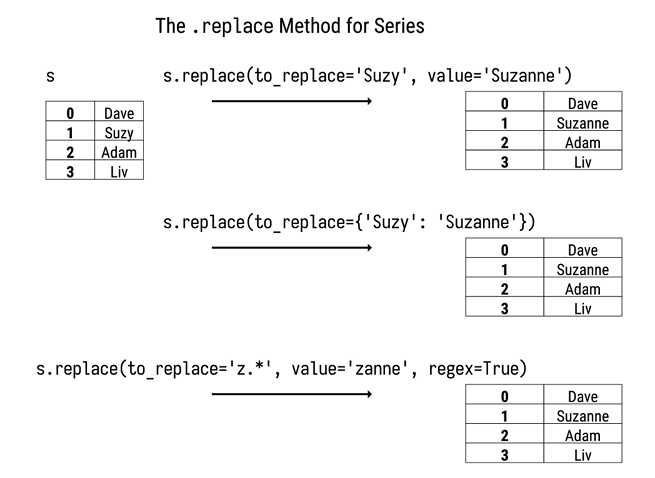

## Binning Data

The following code creates 10 bins of equal width. As the values range from 6 to 150, each bin's width is 14.4

In [62]:
pd.cut(city_mpg, 10)

0        (5.856, 20.4]
1        (5.856, 20.4]
2         (20.4, 34.8]
3        (5.856, 20.4]
4        (5.856, 20.4]
             ...      
41139    (5.856, 20.4]
41140    (5.856, 20.4]
41141    (5.856, 20.4]
41142    (5.856, 20.4]
41143    (5.856, 20.4]
Name: city08, Length: 41144, dtype: category
Categories (10, interval[float64, right]): [(5.856, 20.4] < (20.4, 34.8] < (34.8, 49.2] < (49.2, 63.6] ... (92.4, 106.8] < (106.8, 121.2] < (121.2, 135.6] < (135.6, 150.0]]

We can also specify the bin edges:

In [63]:
pd.cut(city_mpg, [0, 10, 20, 40, 70, 150])

0        (10, 20]
1         (0, 10]
2        (20, 40]
3         (0, 10]
4        (10, 20]
           ...   
41139    (10, 20]
41140    (10, 20]
41141    (10, 20]
41142    (10, 20]
41143    (10, 20]
Name: city08, Length: 41144, dtype: category
Categories (5, interval[int64, right]): [(0, 10] < (10, 20] < (20, 40] < (40, 70] < (70, 150]]

Notice that the above doesn't include the initial value. So for example, if there were values of 0 they would not be considered.

We can also bin according to quantiles. If we'd like 10 bins with (approximately) the same number of values, the qcut comes in handy

In [64]:
pd.qcut(city_mpg, 10)

0         (18.0, 20.0]
1        (5.999, 13.0]
2         (21.0, 24.0]
3        (5.999, 13.0]
4         (16.0, 17.0]
             ...      
41139     (18.0, 20.0]
41140     (18.0, 20.0]
41141     (17.0, 18.0]
41142     (17.0, 18.0]
41143     (15.0, 16.0]
Name: city08, Length: 41144, dtype: category
Categories (10, interval[float64, right]): [(5.999, 13.0] < (13.0, 14.0] < (14.0, 15.0] < (15.0, 16.0] ... (18.0, 20.0] < (20.0, 21.0] < (21.0, 24.0] < (24.0, 150.0]]

Both the cut and qcut function allows to set the labels to use instead of the ones derived from the intervals:

In [65]:
pd.qcut(city_mpg, 10, labels=list(range(1,11)))

0        7
1        1
2        9
3        1
4        5
        ..
41139    7
41140    7
41141    6
41142    6
41143    4
Name: city08, Length: 41144, dtype: category
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

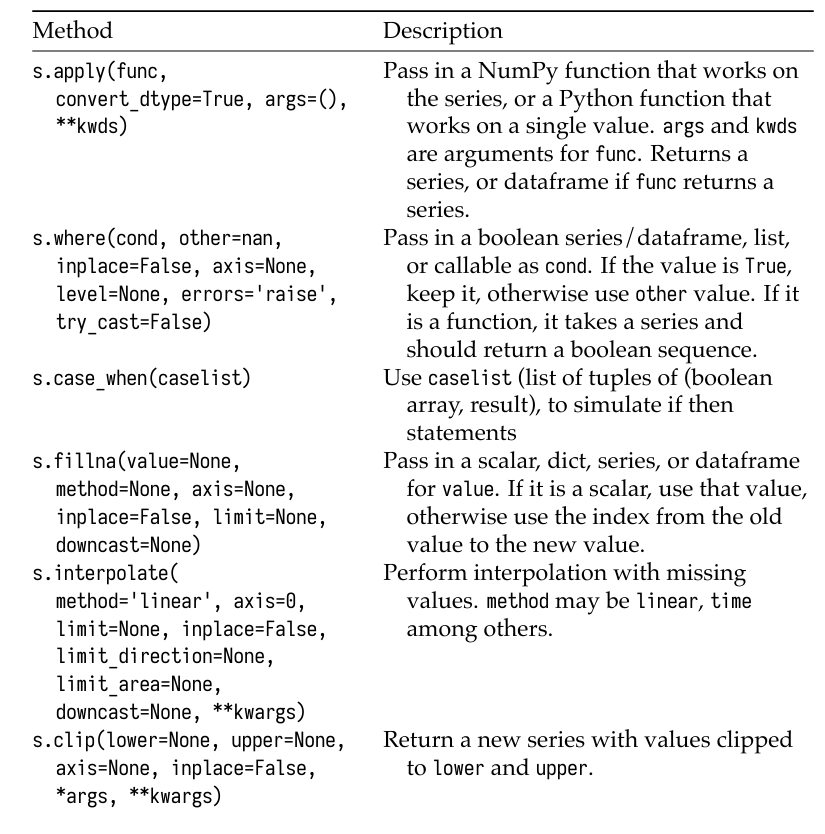

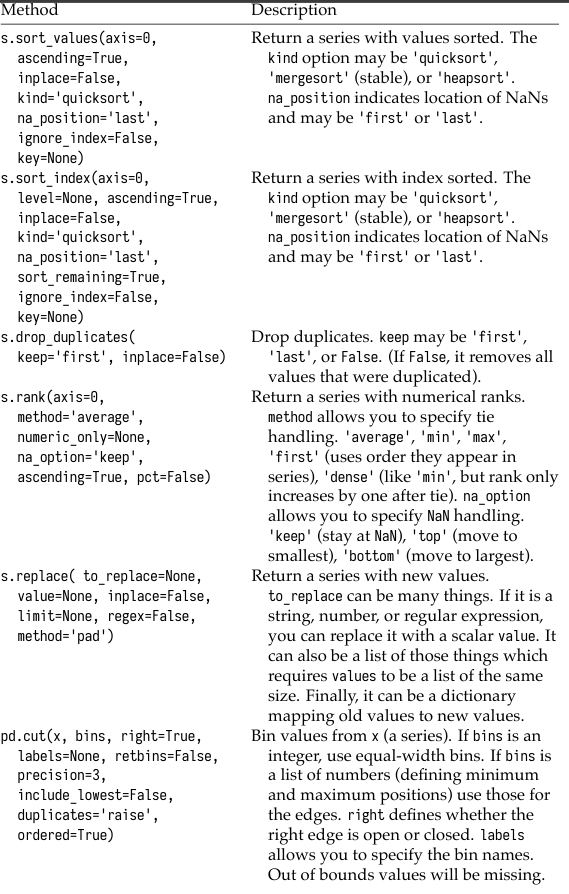

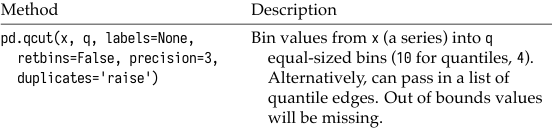

## Excercises

### 1. Create a series from a numeric column that has the value of 'high' if it is equal to or above the mean and 'low' if it is below the mean using .apply.

In [68]:
barrels08 = df.barrels08

In [71]:
b_mean = barrels08.mean()

In [ ]:
def high_low_mean(val):
    if val >= b_mean:
        return "High"
    return "Low"

In [70]:
(
    barrels08
    .apply(high_low_mean)
)

0         Low
1        High
2         Low
3        High
4        High
         ... 
41139     Low
41140     Low
41141     Low
41142     Low
41143    High
Name: barrels08, Length: 41144, dtype: object

In [73]:
# Improved, not yet explored version
barrels08.apply(lambda val: "High" if val >= b_mean else "Low")

0         Low
1        High
2         Low
3        High
4        High
         ... 
41139     Low
41140     Low
41141     Low
41142     Low
41143    High
Name: barrels08, Length: 41144, dtype: object

### 2. Create a series from a numeric column that has the value of 'high' if it is equal to or above the mean and 'low' if it is below the mean using .case_when.

In [74]:
barrels08.case_when(
    caselist=[
        (barrels08 >= b_mean, "High"),
        (barrels08 < b_mean, "Low")
    ]
)

0         Low
1        High
2         Low
3        High
4        High
         ... 
41139     Low
41140     Low
41141     Low
41142     Low
41143    High
Name: barrels08, Length: 41144, dtype: object

### 3. Time the differences between the previous two solutions to see which is faster.

In [78]:
%%timeit
(
    barrels08
    .apply(high_low_mean)
)

1.11 s ± 30.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
%%timeit
barrels08.apply(lambda val: "High" if val >= b_mean else "Low")

5.59 ms ± 336 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [77]:
%%timeit
barrels08.case_when(
    caselist=[
        (barrels08 >= b_mean, "High"),
        (barrels08 < b_mean, "Low")
    ]
)

4.12 ms ± 459 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 4. Replace the missing values of a numeric series with the median value.

In [84]:
null_columns = df.columns[df.isnull().any()]
df[null_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41144 entries, 0 to 41143
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   cylinders   40938 non-null  int64[pyarrow] 
 1   displ       40940 non-null  double[pyarrow]
 2   drive       39955 non-null  string[pyarrow]
 3   eng_dscr    24991 non-null  string[pyarrow]
 4   trany       41133 non-null  string[pyarrow]
 5   guzzler     2423 non-null   string[pyarrow]
 6   trans_dscr  15047 non-null  string[pyarrow]
 7   tCharger    6872 non-null   string[pyarrow]
 8   sCharger    840 non-null    string[pyarrow]
 9   atvType     3560 non-null   string[pyarrow]
 10  fuelType2   1606 non-null   string[pyarrow]
 11  rangeA      1601 non-null   string[pyarrow]
 12  evMotor     852 non-null    string[pyarrow]
 13  mfrCode     10326 non-null  string[pyarrow]
 14  c240Dscr    81 non-null     string[pyarrow]
 15  c240bDscr   79 non-null     string[pyarrow]
 16  star

In [85]:
displ = df.displ

In [88]:
displ[displ.isna()]

7138     <NA>
7139     <NA>
8143     <NA>
8144     <NA>
8146     <NA>
         ... 
34563    <NA>
34564    <NA>
34565    <NA>
34566    <NA>
34567    <NA>
Name: displ, Length: 204, dtype: double[pyarrow]

In [89]:
displ.fillna(displ.median()).loc[7136:7141]

7136    3.3
7137    3.3
7138    3.0
7139    3.0
7140    3.0
7141    3.2
Name: displ, dtype: double[pyarrow]

### 5. Clip the values of a numeric series between to 10th and 90th percentiles.

In [91]:
(
    barrels08
    .clip(
        lower=barrels08.quantile(.1),
        upper=barrels08.quantile(.9)
    )
)

0        15.695714
1        23.543571
2        12.207778
3        23.543571
4        17.347895
           ...    
41139    14.982273
41140     14.33087
41141    15.695714
41142    15.695714
41143    18.311667
Name: barrels08, Length: 41144, dtype: double[pyarrow]

###  6. Using a categorical column, replace any value that is not in the top 5 most frequent values with 'Other'.

In [101]:
df.select_dtypes(include=["string[pyarrow]"]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41144 entries, 0 to 41143
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   drive       39955 non-null  string[pyarrow]
 1   eng_dscr    24991 non-null  string[pyarrow]
 2   fuelType    41144 non-null  string[pyarrow]
 3   fuelType1   41144 non-null  string[pyarrow]
 4   make        41144 non-null  string[pyarrow]
 5   model       41144 non-null  string[pyarrow]
 6   mpgData     41144 non-null  string[pyarrow]
 7   trany       41133 non-null  string[pyarrow]
 8   VClass      41144 non-null  string[pyarrow]
 9   guzzler     2423 non-null   string[pyarrow]
 10  trans_dscr  15047 non-null  string[pyarrow]
 11  tCharger    6872 non-null   string[pyarrow]
 12  sCharger    840 non-null    string[pyarrow]
 13  atvType     3560 non-null   string[pyarrow]
 14  fuelType2   1606 non-null   string[pyarrow]
 15  rangeA      1601 non-null   string[pyarrow]
 16  evMo

In [105]:
fuel_type = df.fuelType

In [109]:
top5 = fuel_type.value_counts().index[:5]
top5

Index(['Regular', 'Premium', 'Gasoline or E85', 'Diesel', 'Electricity'], dtype='string[pyarrow]', name='fuelType')

In [114]:
fuel_type.case_when(caselist=[
    (fuel_type.isin(top5), fuel_type),
    (pd.Series(True, index=fuel_type.index), "Other")
])

0        Regular
1        Regular
2        Regular
3        Regular
4        Premium
          ...   
41139    Regular
41140    Regular
41141    Regular
41142    Regular
41143    Premium
Name: fuelType, Length: 41144, dtype: object

### 7. Using a categorical column, replace any value that is not in the top 10 most frequent values with 'Other'.

In [119]:
fuel_type.nunique()

14

In [115]:
top10 = fuel_type.value_counts().index[:10]
top10

Index(['Regular', 'Premium', 'Gasoline or E85', 'Diesel', 'Electricity',
       'Premium or E85', 'Midgrade', 'CNG', 'Premium and Electricity',
       'Regular Gas and Electricity'],
      dtype='string[pyarrow]', name='fuelType')

In [116]:
fuel_type.case_when(caselist=[
    (fuel_type.isin(top10), fuel_type),
    (pd.Series(True, index=fuel_type.index), "Other")
])

0        Regular
1        Regular
2        Regular
3        Regular
4        Premium
          ...   
41139    Regular
41140    Regular
41141    Regular
41142    Regular
41143    Premium
Name: fuelType, Length: 41144, dtype: object

###  8. Make a function that takes a categorical series and a number (n) and returns a replace series that replaces any value not in the top n most frequent values with 'Other'.

In [120]:
def otheriser(ser, n):
    top_n = ser.value_counts().index[:n]
    return ser.case_when(caselist=[
        (ser.isin(top_n), ser),
        (pd.Series(True, index=fuel_type.index), "Other")
    ])

In [121]:
model = df.model

In [126]:
otheriser(model, 100)

0                      Other
1                      Other
2                    Charger
3        B150/B250 Wagon 2WD
4                      Other
                ...         
41139                  Other
41140                  Other
41141             Legacy AWD
41142             Legacy AWD
41143                  Other
Name: model, Length: 41144, dtype: object

###  9. Using a numeric column, bin it into 10 groups with the same width.

In [127]:
pd.cut(barrels08, 10)

0        (14.168, 18.871]
1        (28.276, 32.979]
2         (9.465, 14.168]
3        (28.276, 32.979]
4        (14.168, 18.871]
               ...       
41139    (14.168, 18.871]
41140    (14.168, 18.871]
41141    (14.168, 18.871]
41142    (14.168, 18.871]
41143    (14.168, 18.871]
Name: barrels08, Length: 41144, dtype: category
Categories (10, interval[float64, right]): [(0.013, 4.763] < (4.763, 9.465] < (9.465, 14.168] < (14.168, 18.871] ... (28.276, 32.979] < (32.979, 37.682] < (37.682, 42.384] < (42.384, 47.087]]

### 10. Using a numeric column, bin it into 10 groups that have equal-sized bins.

In [128]:
pd.qcut(barrels08, 10)

0        (14.982, 15.696]
1        (23.544, 47.087]
2         (0.059, 12.208]
3        (23.544, 47.087]
4         (16.48, 17.372]
               ...       
41139    (13.734, 14.982]
41140    (13.734, 14.982]
41141    (14.982, 15.696]
41142    (14.982, 15.696]
41143    (17.372, 19.389]
Name: barrels08, Length: 41144, dtype: category
Categories (10, interval[float64, right]): [(0.059, 12.208] < (12.208, 13.734] < (13.734, 14.982] < (14.982, 15.696] ... (17.372, 19.389] < (19.389, 20.601] < (20.601, 23.544] < (23.544, 47.087]]